Series de Tiempo (Datos VS Tiempo)

Es una secuencia de datos recolectado en intervalos regulares de tiempo. Se utiliza para analizar fenómenos que cambian con el tiempo, como ventas mensuales, precios diarios, temperatura por hora.

Componentes: 
* Tendencia
* Estacionalidad
* Ciclos
* Ruido

Importancia:
* Predicción de valores futuros
* Detección de patrones y anomalías
* Toma de decisiones
* Planeación de recursos

Una serie de tiempo debe de_
* Tener una media constante
* Varianza constante
* Estructura temporal constante

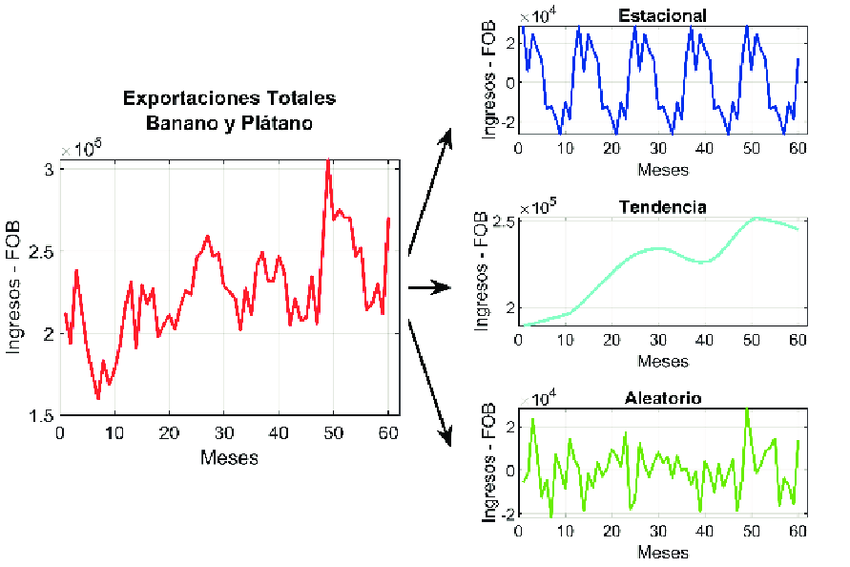






ARIMA: Modelo estadístico usado para analizar y predecir series de tiempo

* Autoregresivo: Usa los valores pasados para predecir el actual
* Integrado: Diferencia de datos para volverlos estacioanrios.
* Media: Usa los erros de predicción paraa mejorar la predición actual.

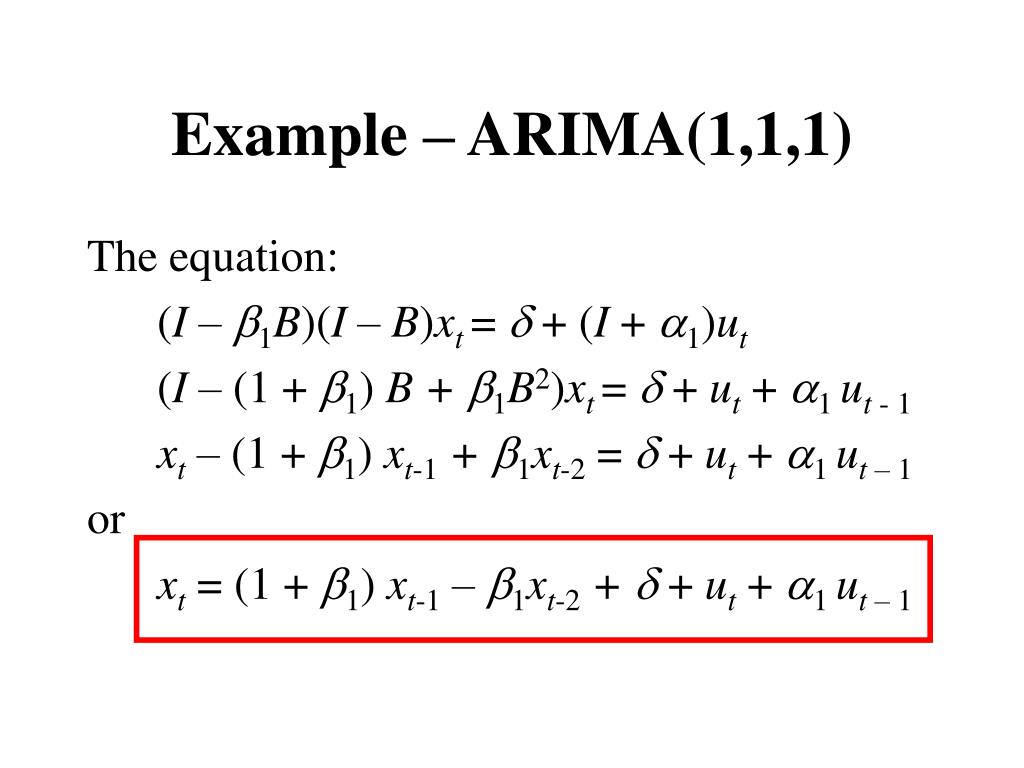

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [52]:
from pmdarima import auto_arima
from IPython.display import display, HTML
pd.options.display.float_format = '{:,.2f}'.format
datos_ventas = pd.read_csv('C:\\Users\\yetla\\Downloads\\forecast.csv')
display(datos_ventas.head(10))

,periodo,ventas
0,2001-6,"665,262.96"
1,2001-7,"2,573,039.56"
2,2001-8,"2,104,739.32"
3,2001-9,"1,642,062.77"
4,2001-10,"3,666,605.86"
5,2001-11,"2,860,528.74"
6,2001-12,"1,774,872.60"
7,2002-1,"3,188,935.63"
8,2002-2,"2,539,739.50"
9,2002-3,"1,877,312.48"


In [6]:
#Nos interesa mostrar la cola
datos_ventas.tail()

,periodo,ventas
33,2004-3,"4,566,378.74"
34,2004-4,"6,252,689.90"
35,2004-5,"6,609,300.99"
36,2004-6,"2,106,732.50"
37,2004-7,"54,151.48"


In [3]:
#Checamos los tipos de datos
datos_ventas.dtypes

periodo     object
ventas     float64
dtype: object

In [53]:
#Psaremos a convertir el periodo a datetime
datos_ventas['periodo'] = pd.to_datetime(datos_ventas['periodo'], format='%Y-%m')
#Comprobamos el cambio  
datos_ventas.dtypes

periodo    datetime64[ns]
ventas            float64
dtype: object

In [54]:
#Procedemos a indexar el periodo, es decir convertir la lcolumna period en el índice del df
datos_ventas.set_index('periodo', inplace=True)
#Comprobamos que el índice es correcto  
datos_ventas.index 

DatetimeIndex(['2001-06-01', '2001-07-01', '2001-08-01', '2001-09-01',
               '2001-10-01', '2001-11-01', '2001-12-01', '2002-01-01',
               '2002-02-01', '2002-03-01', '2002-04-01', '2002-05-01',
               '2002-06-01', '2002-07-01', '2002-08-01', '2002-09-01',
               '2002-10-01', '2002-11-01', '2002-12-01', '2003-01-01',
               '2003-02-01', '2003-03-01', '2003-04-01', '2003-05-01',
               '2003-06-01', '2003-07-01', '2003-08-01', '2003-09-01',
               '2003-10-01', '2003-11-01', '2003-12-01', '2004-01-01',
               '2004-02-01', '2004-03-01', '2004-04-01', '2004-05-01',
               '2004-06-01', '2004-07-01'],
              dtype='datetime64[ns]', name='periodo', freq=None)

<Axes: xlabel='periodo'>

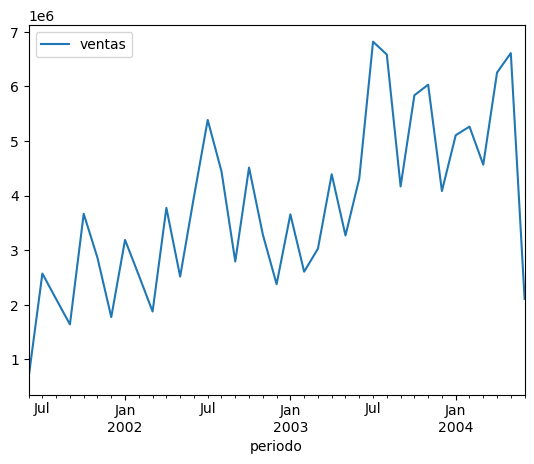

In [55]:
#usualmente si queremos eliminar el ultimo observación por algun error
datos_ventas.drop(datos_ventas.tail(1).index, inplace=True)
#Ahora para poder observar el comportamiento de nuestros datos de una forma visual
datos_ventas.plot()




Ahora es tiempo de verificar si mi serie de tiempo es estacionaria?
Recordmeos que una serie es estacioanria si , tiene media constante y varianza  constante.

Una raíz unitaria desde el punto de vista estadístico, significa que la serie dde tiempo tiene memoria a largo plazo, es decir, que el valor de hoy depende del valor de ayer.

Por lo tanto una serie con raíz unitaria no es estacionaria. Lo anterior nos lleva a anaizar la prueba de Dickey-Fuller y por la tanto necesitamos introducir la hipotesis nula y la hipoteisis alternativa.


* Hipotesis nula: La serie tiene una raíz unitaria y por lo tanto no es estacionaria.
* Hipotesis alternativa: La serie no tiene raíz unitaria, esto impic a que es estacioanria. 

La prueba poseee un nivel de significancia que indica la porbabilidad de que la hipotesis nula sea cierto.
* si p es amyor de 0.5 la serie no es estacionaria, no se rechaza la hipotesis nula, es decir la sserie es estacionaria.
* si p es menor de 0.5 se rechaza la hipotesis nula, es decir la serie es estacioanria.


In [56]:
#Probemos la estacionalidad de nuestros datos
#from pmdarima import ADFTest # La prueba de dickfuller 
from pmdarima.arima.stationarity import ADFTest  # Importa ADFTest desde el módulo correcto
adf_test = ADFTest(alpha=0.05) # 5% de significancia
#Esto quiere decir que solicitamos un 95% de confianza
#El resultado nos dice si los datos son estacionarios o no, si son estacionarios no es necesario diferenciar los datos
adf_test.should_diff(datos_ventas)


(0.2570208182830874, True)

Debido a que genera un valor encima de 0.05 entonces hay un alata probabilidad de que la serie tenga raíz unitaria es decir NO ES ESTACIONARIA.

Recordemos que si la serie tiene raíz unitaria, es decir, no es estacionaria la serie posee tendencia (creciente o decreciente) y por lo tanto no es confiable oara modelar. Lo cual implica que hay que aplicat un tratamiento de los datos de la serie. Esta vez aplicaremos la DIFERENCIACIÓN.

Diferenciació es una formula recursiva: Y = Yt - Yt-1

<Axes: xlabel='periodo'>

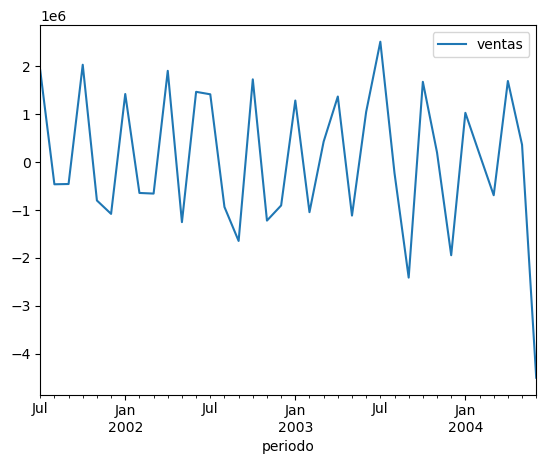

In [57]:
#Aplicamos diferenciación estacional a los datos
datos_ventas_diff = datos_ventas.diff().dropna()

#Ahora si, checamos VISUALMENTE 
datos_ventas_diff.plot()

In [58]:
adf_test.should_diff(datos_ventas_diff)

(0.1677259396641974, True)

In [62]:
#Procedemosa construir los conjuntos de entrenamiento y prueba
train = datos_ventas.iloc[:85].dropna()
test = datos_ventas[-20:]

#Mostrar el conjunto de entrenamiento y prueba
print("Conjunto de entrenamiento")
train.tail()


Conjunto de entrenamiento


,ventas
periodo,
2004-02-01,"5,263,451.43"
2004-03-01,"4,566,378.74"
2004-04-01,"6,252,689.90"
2004-05-01,"6,609,300.99"
2004-06-01,"2,106,732.50"


In [64]:
test.head()


,ventas
periodo,
2002-11-01,"3,288,061.47"
2002-12-01,"2,378,170.42"
2003-01-01,"3,656,427.52"
2003-02-01,"2,606,553.82"
2003-03-01,"3,028,796.56"


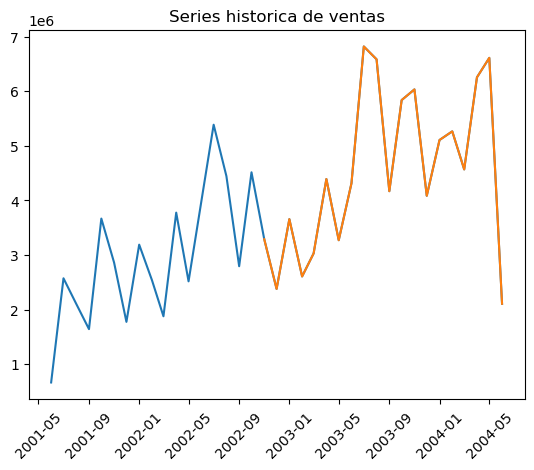

In [65]:

#Ahora si, checamos VISUALMENTE el conjunto de entrenamiento y prueba
plt.plot(train, label='Entrenamiento')
plt.plot(test, label='Prueba')
plt.xticks(rotation=45)
plt.title("Series historica de ventas")
plt.show()

In [66]:
# Configuración del modelo ARIMA
arima_model = auto_arima(train, start_p=0, d=1, start_q=0,
                        #De que valor se comienza la busqueda de parametros
                         max_p=5, max_d=5, max_q=5,
                         #
                         D=1, start_Q=0, max_P=5, max_D=5,
                         #
                         max_Q=5, m=12, seasonal=True,
                         #
                         error_action="warn", trace=True,
                         suppress_warnings=True, stepwise=True,
                         random_state=20, n_fits=50)



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=753.923, Time=0.03 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=751.068, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=747.028, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=746.432, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=745.619, Time=0.00 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=746.374, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=748.335, Time=0.07 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=746.019, Time=0.03 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=745.898, Time=0.02 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=745.308, Time=0.01 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=747.094, Time=0.03 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=748.629, Time=0.07 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=744.064, Time=0.02 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=744.721, Time=0.05 sec
 ARIMA(2,1,0)(0,1,1)[12]         

In [67]:
# Imprimir el resumen del modelo ajustado
print(arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   37
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -369.032
Date:                            Thu, 10 Apr 2025   AIC                            744.064
Time:                                    10:25:20   BIC                            747.598
Sample:                                06-01-2001   HQIC                           745.001
                                     - 06-01-2004                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9310      0.239     -3.902      0.000      -1.399      -0.463
ar.L2         -0.5928      0.495   

In [68]:
# Predecir los próximos 12 períodos (meses)
Prediccion = pd.DataFrame(arima_model.predict(n_periods=12))
Prediccion.columns = ["Prediccion_sales"]
Prediccion


,Prediccion_sales
2004-07-01,"8,898,386.23"
2004-08-01,"7,959,103.30"
2004-09-01,"3,658,813.99"
2004-10-01,"7,500,113.10"
2004-11-01,"6,789,919.34"
2004-12-01,"4,396,633.41"
2005-01-01,"6,369,503.59"
2005-02-01,"5,906,423.06"
2005-03-01,"5,224,270.77"
2005-04-01,"7,265,105.29"


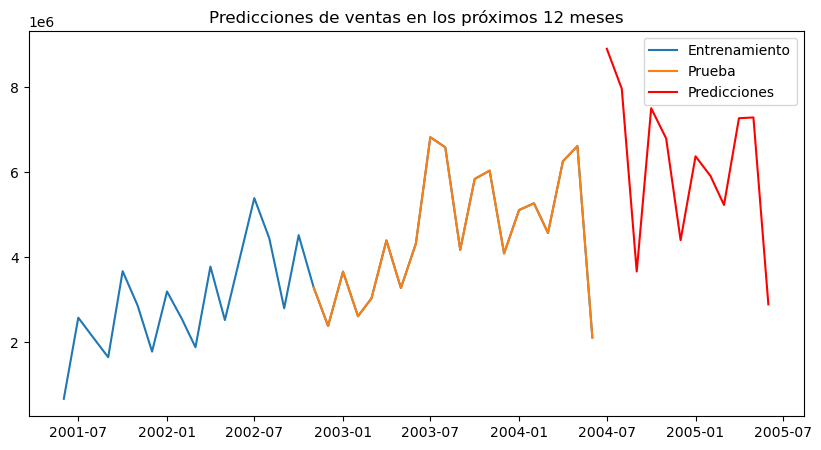

In [71]:
#Graficamos las predicciones
plt.figure(figsize=(10, 5))
plt.plot(train, label='Entrenamiento')
plt.plot(test, label='Prueba')
plt.plot(Prediccion, label='Predicciones', color='red')
plt.title("Predicciones de ventas en los próximos 12 meses")
plt.legend(loc = "best")
plt.show()

Ejercicio

Analizar mediante series de tiempo si los 13 salones (espacios educativos disponibles en la sede Coyoacán) serán suficientes ante el crecimiento en el número de estudiantes que ingresan cada 6 meses.

In [1]:
#Coemzamos importando las librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from pmdarima import auto_arima
from IPython.display import display, HTML
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
#Cargamos los datos 
datos = pd.read_csv("C:\\Users\\yetla\\Downloads\\PYTHON\\predicciones_estudiantes_arima.csv")
#Y mostramos los mostramos
display(datos)

,fecha,predicted,salones_necesarios
0,2029-01-01,685.07,23.00
1,2029-07-01,698.15,24.00
2,2030-01-01,711.22,24.00
3,2030-07-01,724.30,25.00


In [3]:
#Checamos los tipos de datos
datos.dtypes

fecha                  object
predicted             float64
salones_necesarios    float64
dtype: object

In [4]:
#Cambiamos el tipo de dato de la columna periodo a datetime
#Estos cambios son necesarios para poder graficar los datos de forma correcta
#y para poder hacer predicciones
datos['fecha'] = pd.to_datetime(datos['fecha'])
# Comprobamos el cambio
datos.dtypes

fecha                 datetime64[ns]
predicted                    float64
salones_necesarios           float64
dtype: object

In [5]:
#Ahora agregamos la columna fecha como el índice del df
datos.set_index('fecha', inplace=True)
#Comprobamos que el índice es correcto
datos.index

DatetimeIndex(['2029-01-01', '2029-07-01', '2030-01-01', '2030-07-01'], dtype='datetime64[ns]', name='fecha', freq=None)

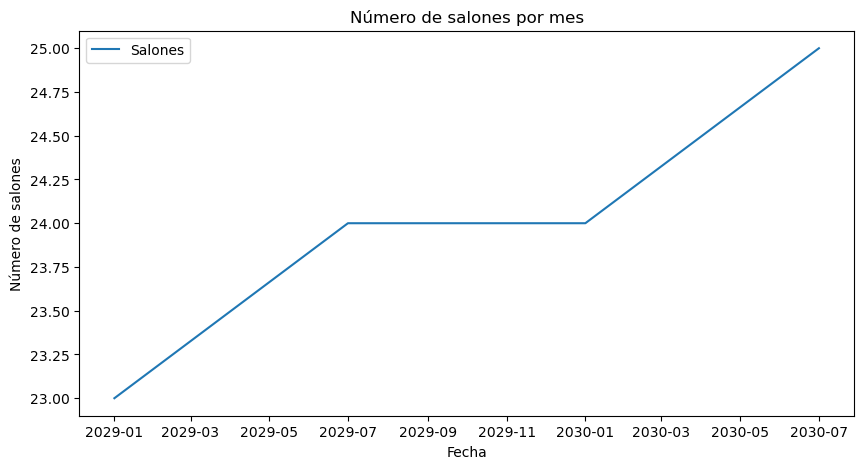

In [6]:
#Graficamos los datos, para ver el comportamiento de los datos
#Donde el eje x es el numero de salones 
#y el eje y es la fecha
plt.figure(figsize=(10, 5))
plt.plot(datos['salones_necesarios'], label='Salones')
plt.title("Número de salones por mes")
plt.xlabel("Fecha")
plt.ylabel("Número de salones")
plt.legend(loc='best')
plt.show()

Antes de continuar con el modelo ARIMA, es importante verificar si los datos son estacionarios o no.


Dado que la prueba ADF internamente utiliza regresión lineal (OLS), y necesita suficientes datos para calcular los coeficientes y residuos. Con solo 4 puntos de datos, no hay suficiente información estadística para hacer esto bien. Así que procederemos sin la prueba, asumiremos no estacionariedad y aplicaremos la diferenciación manueal. 

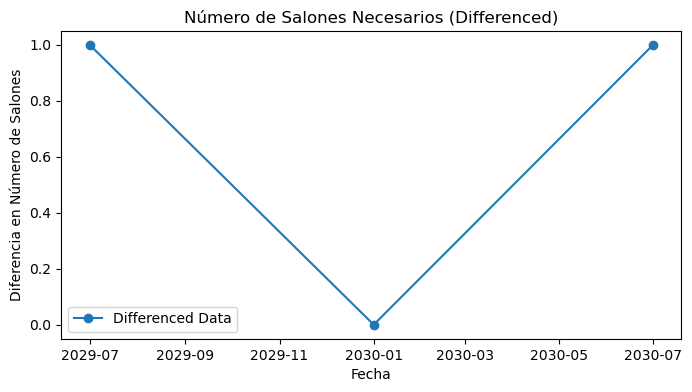

In [8]:
# Aplicamos la prueba de Dickey-Fuller manualmente
data_diff = datos['salones_necesarios'].diff().dropna()

# Visualización de los datos diferenciados
plt.figure(figsize=(8, 4))
plt.plot(data_diff, marker='o', label='Differenced Data')
plt.title("Número de Salones Necesarios (Differenced)")
plt.xlabel("Fecha")
plt.ylabel("Diferencia en Número de Salones")
plt.legend()
plt.show()

In [9]:
#Usaremos auto_arima() para buscar los mejores parámetros automáticamente:
from pmdarima import auto_arima

# Ajustar el modelo ARIMA automáticamente sobre la serie original
modelo = auto_arima(datos['salones_necesarios'],
                    start_p=0, start_q=0,
                    max_p=2, max_q=2,
                    d=1,  # ya diferenciamos manualmente
                    seasonal=False,
                    stepwise=True,
                    suppress_warnings=True,
                    trace=True)

# Mostrar resumen del modelo
print(modelo.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8.001, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.297, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.521 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                    4
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  -2.001
Date:                Wed, 23 Apr 2025   AIC                              8.001
Time:                        22:42:50   BIC                              6.199
Sample:                    01-01-2029   HQIC                             4.378
                         - 07-01-2030                                         
Covariance Type:  

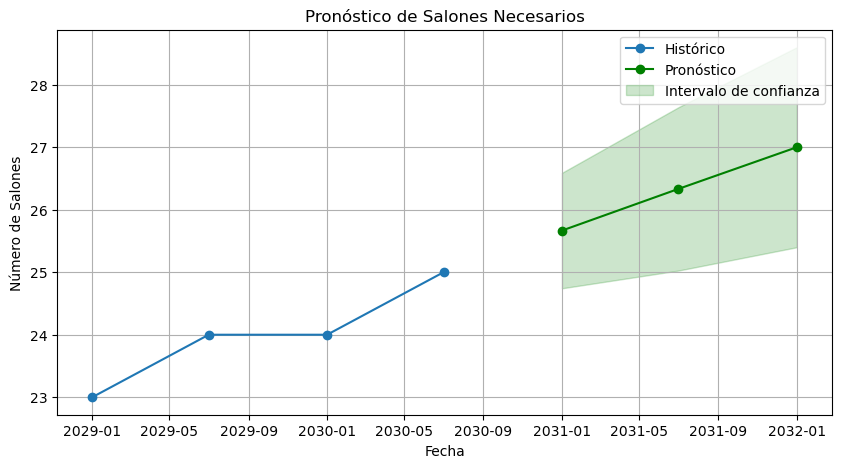

In [12]:
#Supongamos que queremos predecir n meses (3 meses en este caso):
# Predecir los siguientes 3 valores
n_periodos = 3
predicciones, conf_int = modelo.predict(n_periods=n_periodos, return_conf_int=True)

# Crear fechas futuras
fechas_futuras = pd.date_range(start=datos.index[-1] + pd.DateOffset(months=6), periods=n_periodos, freq='6MS')

# Crear DataFrame de predicciones
df_predicciones = pd.DataFrame({
    'fecha': fechas_futuras,
    'predicted_salones': predicciones,
    'lower_bound': conf_int[:, 0],
    'upper_bound': conf_int[:, 1]
})
df_predicciones.set_index('fecha', inplace=True)

# Visualizar
plt.figure(figsize=(10, 5))
plt.plot(datos['salones_necesarios'], label='Histórico', marker='o')
plt.plot(df_predicciones['predicted_salones'], label='Pronóstico', marker='o', color='green')
plt.fill_between(df_predicciones.index, df_predicciones['lower_bound'], df_predicciones['upper_bound'], 
                 color='green', alpha=0.2, label='Intervalo de confianza')
plt.title('Pronóstico de Salones Necesarios')
plt.xlabel('Fecha')
plt.ylabel('Número de Salones')
plt.legend()
plt.grid()
plt.show()


## 📈 Crecimiento constante:
La serie temporal muestra una tendencia creciente en el número de salones necesarios.   

---

## 🚫 Insuficiencia clara:
Dado que en la sede **Coyoacán** actualmente hay solo **13 salones disponibles**, la demanda proyectada casi **duplica** la capacidad actual.  
👉 Esto representa una **brecha muy significativa**.  

---

## ⚠️ Alto riesgo de saturación:
Si no se amplían los espacios educativos, es altamente probable que se presente **saturación**, **hacinamiento** o **rechazo de estudiantes**, especialmente en los **próximos dos años**.  

---

## 📊 El pronóstico es estable pero firme:
Aunque el modelo proyecta de forma bastante **lineal**, el intervalo de confianza sugiere cierta **incertidumbre**,  
pero en **ningún caso baja de 24-25 salones**, lo cual sigue estando **muy por encima** de los **13 disponibles**.  
